In [1]:
# This file is used to generate figures like those seen in the SI section of the paper.

In [2]:
from Bio import SeqIO
from insights import *
from processSequences import *
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

path = "CP068277.2.gb" # Chromosome 1
# path = "CP068271.2.gb" # Chromosome 7
restriction_sequence = "GATC"
enzyme_name = "MboI"

telomere_buffer = int(20 * 1E6) # Number of bp to remove on ends
unmappable_start = int(115 * 1E6)
unmappable_end = int(150 * 1E6)

In [3]:
# Read the record
record = SeqIO.read("Sequences/Human Genome T2T/" + path, "genbank")
seq = record.seq
print("Sequence " + record.name + " of length " + str(len(record.seq)))

Sequence CP068277 of length 248387328


In [4]:
plt.rcParams.update({
    'font.size': 14,      # Base font size for all elements
    'axes.titlesize': 18, # Font size for the title
    'axes.labelsize': 16, # Font size for the x and y labels
    'xtick.labelsize': 12, # Font size for the x tick labels
    'ytick.labelsize': 12, # Font size for the y tick labels
    'legend.fontsize': 14, # Font size for the legend
    'figure.titlesize': 20 # Font size for the figure title
})

In [5]:
# Find the restriction sites
instances = np.array(site_instances(seq, restriction_sequence))
distances = np.diff(instances)

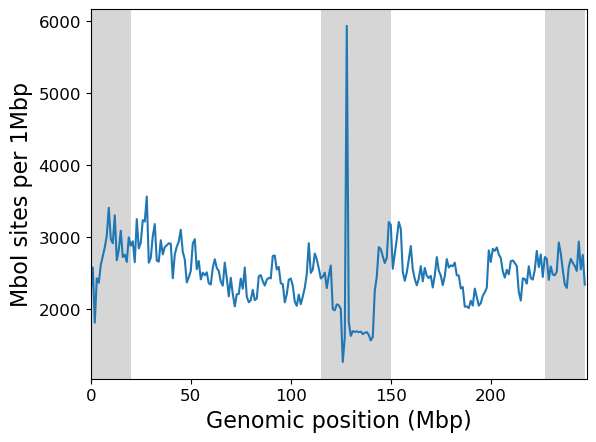

In [6]:
# The number of sites in each genomic bin
binwidth = 1000000 # (in base pairs)

make_divisible = len(seq) - len(seq) % binwidth

bincount = (len(seq) // binwidth) + 1
bins = np.linspace(0, make_divisible, bincount)

counts, _ = np.histogram(instances, bins=bins)

fig, ax = plt.subplots(1)
x = bins[:-1] / 1E6
ax.plot(x, counts)

val, unit = bp_notation(binwidth)
ax.set_ylabel(enzyme_name + " sites per " + '%g'%val + unit)
ax.set_xlim(0, make_divisible / 1E6)
# ax.set_xlabel("Genomic Position (Mbp)")
# ax.get_xaxis().set_visible(False)
ax.set_xlabel("Genomic position (Mbp)")

# Highlight telomere regions
plt.axvspan(0, telomere_buffer / 1E6, facecolor='0.2', alpha=0.2)
plt.axvspan(x[-1] - telomere_buffer / 1E6, x[-1], facecolor='0.2', alpha=0.2)
# Highlight unmappable region
plt.axvspan(unmappable_start / 1E6, unmappable_end / 1E6, facecolor='0.2', alpha=0.2)

In [7]:
outpath = "C:/Users/lbjun/OneDrive/Documents/School/Di Pierro Lab/Supplemental information in silico Hi-C paper/Draft 3"
print(outpath + "/fig1 chr7" + enzyme_name)

C:/Users/lbjun/OneDrive/Documents/School/Di Pierro Lab/Supplemental information in silico Hi-C paper/Draft 3/fig1 chr7MboI


In [8]:
# Truncate the sequence
truncated_seq = seq[telomere_buffer:unmappable_start] + seq[unmappable_end:-telomere_buffer]

# Find the restriction sites
truncated_instances = np.array(site_instances(truncated_seq, restriction_sequence))
truncated_distances = np.diff(truncated_instances)

Text(0.5, 0, 'Genomic Position (Mbp)')

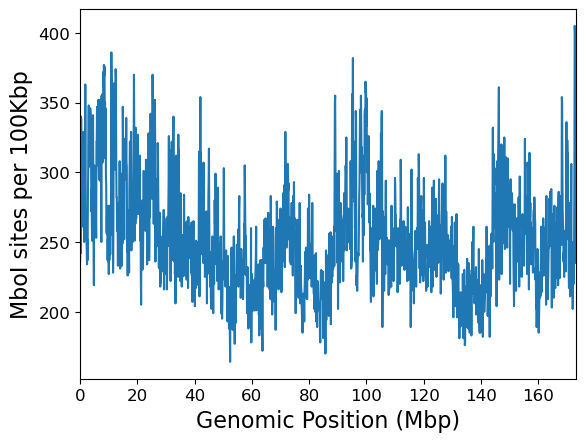

In [9]:
# The number of sites in each genomic bin
binwidth = 100000 # (in base pairs)

make_divisible = len(truncated_seq) - len(truncated_seq) % binwidth

bincount = (len(truncated_seq) // binwidth) + 1
bins = np.linspace(0, make_divisible, bincount)

counts, _ = np.histogram(truncated_instances, bins=bins)

fig, ax = plt.subplots(1)
x = bins[:-1] / 1E6
ax.plot(x, counts)

val, unit = bp_notation(binwidth)
ax.set_ylabel(enzyme_name + " sites per " + '%g'%val + unit)
ax.set_xlim(0, make_divisible / 1E6)
ax.set_xlabel("Genomic Position (Mbp)")
# ax.get_xaxis().set_visible(False)

In [10]:
p_m = len(truncated_instances) / len(truncated_seq)

counts, bins = np.histogram(distances, bins=10000)
binsize = bins[1] - bins[0]

proportion = 0.999
upper_lim = bins[np.where((np.cumsum(counts) / np.sum(counts)) > proportion)[0][0]]
print(upper_lim)

3033.5776


Text(1516.7888, 0.00364911981353182, '$r^2$ = 0.939\n$p_m$ =2.53E-03 $bp^{-1}$\n$\\lambda$ = 395.2 $bp$')

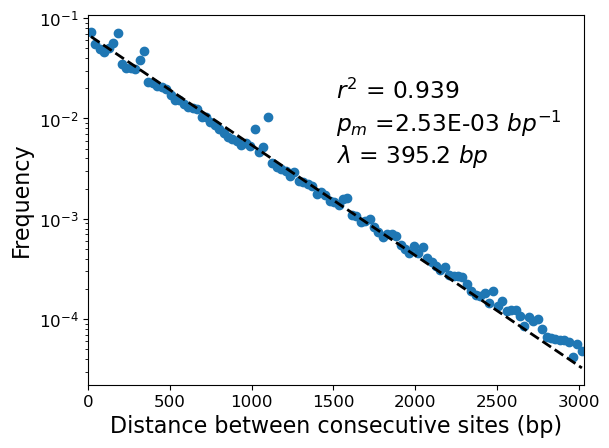

In [11]:
def model(dist):
    return -np.log(1-p_m) * binsize * ((1-p_m) ** dist)

fig, ax = plt.subplots(1)

shifted = bins[1:] - (bins[1] - bins[0]) / 2
counts = counts[shifted < upper_lim]
x = shifted[shifted < upper_lim]
ax.scatter(x, counts / np.sum(counts))
ax.set_yscale('log')

# Model 
y = model(x)
ax.plot(x, y, linestyle='dashed', color='black', linewidth=2)
ax.set_xlabel("Distance between consecutive sites (bp)")
ax.set_ylabel("Frequency")

r_2 = r2_score((counts / np.sum(counts)), y)

ax.set_xlim(0, upper_lim)
ax.text(upper_lim * 0.5, np.max(counts / np.sum(counts)) / 20, r"$r^2$ = %.3f" % r_2 + 
        "\n" + r"$p_m$ =" + f"{p_m:.{2}E}" + r" $bp^{-1}$" + 
        "\n" + r"$\lambda$ = %.1f" % (1/p_m) + r" $bp$", fontsize='large')
# r2_score((counts / np.sum(counts))[x < upper_lim], y[x < upper_lim])